In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/jolivie1/Desktop/Research/equivalence_testing/scripts/')

from equiv_test_funcs_vectorized import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [37]:
def write_sim_files(num, delta, datapath, metapath, geneA_fracs, num_samples):
    data = {"sample" : [], "A" : [], "B" : [], "condition" : []}
    count = 0
    for j in range(len(geneA_fracs)):
        for k in range(num_samples):
            count += 1
            n = np.random.poisson(num)
            A = np.random.binomial(n, geneA_fracs[j])
            data["sample"].append("sample" + str(count))
            data["A"].append(A)
            data["B"].append(n - A)
            data["condition"].append(j)
    df = pd.DataFrame(data).set_index("sample")
    meta = df[["condition"]]  
    data = df[[x for x in df.columns if x != "condition"]].T

    #display(data)
    data.to_csv(datapath)
    meta.to_csv(metapath)

def get_significance():
    calc_df = perform_full_analysis(datapath, metapath, "condition", delta)
    
    if "A" in calc_df.index:
        return calc_df.loc["A"]["sig_diff"], calc_df.loc["A"]["sig_equiv"]
    return False, False

def run_simulation(numReads, num_trials, delta, datapath, metapath, geneA_fracs, num_samples):
    out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
           "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : [], 
           "frac_sig_inc" : [], "frac_sig_inc_lower" : [], "frac_sig_inc_upper" : []}

    for num in numReads:
        print("num reads: {}".format(num))
        # collect p vals for each
        num_sig_diff = 0
        num_sig_equiv = 0
        num_inconclusive = 0

        for i in range(num_trials):

            # simulate data
            write_sim_files(num, delta, datapath, metapath, geneA_fracs, num_samples)

            # get results
            diff_sig, equiv_sig = get_significance()

            # save output
            num_sig_diff += diff_sig
            num_sig_equiv += equiv_sig
            num_inconclusive += 1 - diff_sig - equiv_sig

        # get frac significant
        out["numReads"].append(num)

    #    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
        lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
        out["frac_sig_diff"].append(num_sig_diff/num_trials)
        out["frac_sig_diff_lower"].append(lower_ci)
        out["frac_sig_diff_upper"].append(upper_ci)

    #    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
        lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
        out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
        out["frac_sig_equiv_lower"].append(lower_ci)
        out["frac_sig_equiv_upper"].append(upper_ci)


    #    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
        lower_ci, upper_ci = proportion_confint(num_inconclusive, num_trials)
        out["frac_sig_inc"].append(num_inconclusive/num_trials)
        out["frac_sig_inc_lower"].append(lower_ci)
        out["frac_sig_inc_upper"].append(upper_ci)

    out = pd.DataFrame(out)
    return out

In [42]:
np.random.seed(123)

delta = 1
alpha = 0.05

outpath = "/Users/jolivie1/Desktop/Research/equivalence_testing_output/notebooks/output/simulation_vectorize/"

datapath = "{}data.csv".format(outpath)
metapath = "{}meta.csv".format(outpath)

num_samples = 3

#num_trials = 10
num_trials = 100

#geneA_fracs = [0.1, 0.6]
#geneA_fracs = [0.3, 0.6]
#geneA_fracs = [0.2, 0.8]
#geneA_fracs = [0.45, 0.55]
geneA_fracs = [0.1, 0.15]
#geneA_fracs = [0.01, 0.015]
#geneA_fracs = [0.05, 0.1]


#numReads = [5, 10, 50, 100, 500, 1000]
numReads = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200]
#numReads = [1]


In [43]:
out = run_simulation(numReads, num_trials, delta, datapath, metapath, geneA_fracs, num_samples)

num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 15
num reads: 20
num reads: 25
num reads: 30
num reads: 35
num reads: 40
num reads: 45
num reads: 50
num reads: 100
num reads: 150
num reads: 200


In [35]:
out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
       "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : [], 
       "frac_sig_inc" : [], "frac_sig_inc_lower" : [], "frac_sig_inc_upper" : []}

for num in numReads:
    print("num reads: {}".format(num))
    # collect p vals for each
    num_sig_diff = 0
    num_sig_equiv = 0
    num_inconclusive = 0
    
    for i in range(num_trials):
        
        # simulate data
        write_sim_files(num, delta, datapath, metapath, geneA_fracs, num_samples)
        
        # get results
        diff_sig, equiv_sig = get_significance()
        
        # save output
        num_sig_diff += diff_sig
        num_sig_equiv += equiv_sig
        num_inconclusive += 1 - diff_sig - equiv_sig
        
    # get frac significant
    out["numReads"].append(num)

#    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
    out["frac_sig_diff"].append(num_sig_diff/num_trials)
    out["frac_sig_diff_lower"].append(lower_ci)
    out["frac_sig_diff_upper"].append(upper_ci)

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
    out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
    out["frac_sig_equiv_lower"].append(lower_ci)
    out["frac_sig_equiv_upper"].append(upper_ci)
    

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_inconclusive, num_trials)
    out["frac_sig_inc"].append(num_inconclusive/num_trials)
    out["frac_sig_inc_lower"].append(lower_ci)
    out["frac_sig_inc_upper"].append(upper_ci)
    
out = pd.DataFrame(out)
display(out)

num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 15
num reads: 20
num reads: 25
num reads: 30
num reads: 35
num reads: 40
num reads: 45
num reads: 50
num reads: 100
num reads: 150
num reads: 200


,numReads,frac_sig_diff,frac_sig_diff_lower,frac_sig_diff_upper,frac_sig_equiv,frac_sig_equiv_lower,frac_sig_equiv_upper,frac_sig_inc,frac_sig_inc_lower,frac_sig_inc_upper
0,1,0.00,0.000000,0.000000,0.00,0.000000,0.000000,1.00,1.000000,1.000000
1,2,0.00,0.000000,0.000000,0.00,0.000000,0.000000,1.00,1.000000,1.000000
2,3,0.01,0.000000,0.029501,0.00,0.000000,0.000000,0.99,0.970499,1.000000
3,4,0.00,0.000000,0.000000,0.00,0.000000,0.000000,1.00,1.000000,1.000000
4,5,0.00,0.000000,0.000000,0.00,0.000000,0.000000,1.00,1.000000,1.000000
5,10,0.00,0.000000,0.000000,0.06,0.013453,0.106547,0.94,0.893453,0.986547
6,15,0.02,0.000000,0.047439,0.05,0.007284,0.092716,0.93,0.879992,0.980008
7,20,0.02,0.000000,0.047439,0.14,0.071992,0.208008,0.84,0.768147,0.911853
8,25,0.02,0.000000,0.047439,0.11,0.048675,0.171325,0.87,0.804086,0.935914
9,30,0.05,0.007284,0.092716,0.08,0.026828,0.133172,0.87,0.804086,0.935914


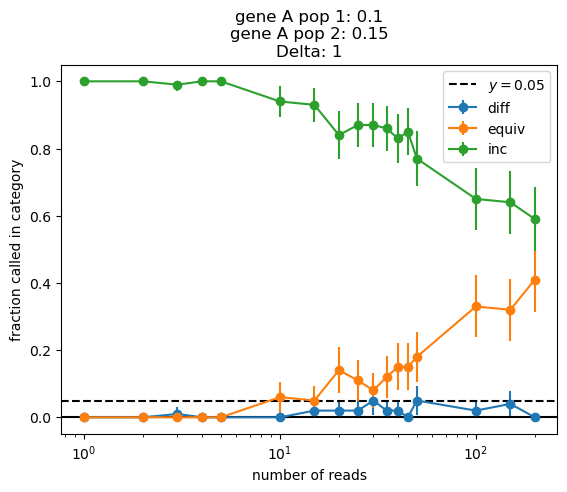

In [44]:
plt.errorbar(out["numReads"], out["frac_sig_diff"], yerr = [out["frac_sig_diff"] - out["frac_sig_diff_lower"],
            out["frac_sig_diff_upper"] - out["frac_sig_diff"] ], marker = "o", label = "diff")
plt.errorbar(out["numReads"], out["frac_sig_equiv"], yerr = [out["frac_sig_equiv"] - out["frac_sig_equiv_lower"],
            out["frac_sig_equiv_upper"] - out["frac_sig_equiv"] ], marker = "o", label = "equiv")
plt.errorbar(out["numReads"], out["frac_sig_inc"], yerr = [out["frac_sig_inc"] - out["frac_sig_inc_lower"],
            out["frac_sig_inc_upper"] - out["frac_sig_inc"] ], marker = "o", label = "inc")
plt.xscale("log")
plt.axhline(y=0.05, linestyle="--", color="k", label = "$y = 0.05$")
plt.axhline(y=0.0, color="k")

plt.legend()
plt.xlabel("number of reads")
plt.ylabel("fraction called in category")
plt.title("gene A pop 1: {}\ngene A pop 2: {}\nDelta: {}".format(geneA_fracs[0], geneA_fracs[1], delta))
plt.savefig("{}pop1_{}_pop2_{}_delt_{}.png".format(outpath, *geneA_fracs, delta),bbox_inches='tight')
plt.show()